# Islamophhobia Detection with mBERT using Keras and TensorFlow 2

In [3]:
!nvidia-smi

Sun Sep 20 14:26:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install tensorflow-gpu 

     |████████████████████████████████| 320.4MB 45kB/s 


In [5]:
!pip install --upgrade grpcio

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.32.0)


In [6]:
!pip install tqdm

In [7]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 3.9MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=13e6245b03d46a845ffe633eb63689ed39f07b82e20def2dd5441c21e337a939
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=25a7efc6c70ebbcc1ee48f995fb6fc70637ea88bb2ca77ef488bc3c1a35e26a4
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=cc1363fdd4e21a0a3fc49ef3d07ca0228ffd5c94b2bff56557a5a7250b73b72a
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [8]:
!pip install googletrans

     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 962kB 14.6MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 102kB 10.8MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=4442f16b6e860e2e4c4478da48134ab5461912b4eb6553402e673429fbf01a93
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=e57b5e20e5349c0779a3bfe48d5e562989cfdab7a854f01b541b7758802b1bee
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [9]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 8.1MB/s 


In [10]:
!pip install googletrans

In [11]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

import re

# translator
import googletrans
from googletrans import Translator

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data


In [12]:
# English dataset
!gdown --id 1XRgPYGmM5I8KnrJFOEDCaRnvD4rbWrqA --output data-task2.csv

Downloading...
From: https://drive.google.com/uc?id=1XRgPYGmM5I8KnrJFOEDCaRnvD4rbWrqA
To: /content/data-task2.csv
100% 815k/815k [00:00<00:00, 110MB/s]


In [13]:
df = pd.read_csv('data-task2.csv', 
                   delimiter=',')
df.columns = ['Text', 'Label']
df.head(15)
df["Text"] = df["Text"].astype(str)
df["Label"] = df["Label"].astype(str)

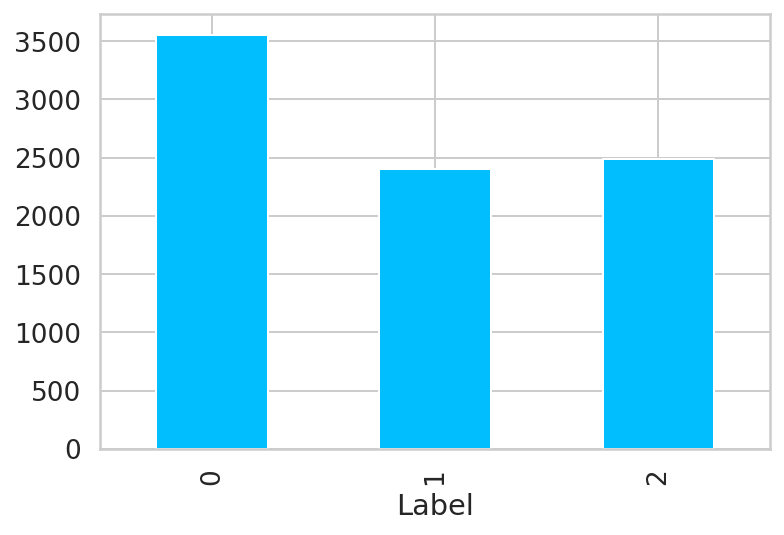

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [15]:

# For entire dataset sentences for each labels 
df.Label.value_counts()

0    3555
2    2485
1    2398
Name: Label, dtype: int64

In [16]:
df=df.sample(frac=1).reset_index(drop=True)
df

,Text,Label
0,'@CuriousPhantomm @TheJaggi He isnâ€™t hindu. ...,0
1,'@dogman_99 CRICKET him and dennis are both la...,0
2,'I have 195 new followers from Pakistan India...,0
3,'Happy Islamic New year #Muharram #NewYear #i...,1
4,'@RyanSidebottom on eggheads.The whole of Hudd...,0
...,...,...
8433,'@chedetofficial Elephant walks DOGs bark. Ke...,2
8434,'Training sessions in Sri Lanka to hold sway i...,0
8435,'@Awan_0786_ You too my dear brotherðŸ’–ðŸ’–,1
8436,'Happy muharram islamic new year #islamicnewyear,1


Data Preprocessing

In [17]:
def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceFourColon(x))

In [18]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

df['Text'] = df['Text'].apply(lambda x: textPattern(x))

In [19]:
df = df[df.Text != '']

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.10, random_state=42)

In [21]:
df=df.sample(frac=1).reset_index(drop=True)

In [22]:
df.head()

,Text,Label
0,Facebook s Mark Zuckerberg Amazon s Jeff Bezo...,0
1,cricket badger just because other players did...,0
2,The cricket has won and I am hoping for a sev...,0
3,EkamSat1 DuneKhaal Here you go A Muslim siste...,1
4,Ethan is a Writer and his friend Emma is a Pl...,0


# Islamophhobia Detection with BERT


In [23]:
!gdown --id 1ds0mgIfyRZ1vTdQCT4Q5EOxTFA1vH47a --output multi_cased_L-12_H-768_A-12.zip

Downloading...
From: https://drive.google.com/uc?id=1ds0mgIfyRZ1vTdQCT4Q5EOxTFA1vH47a
To: /content/multi_cased_L-12_H-768_A-12.zip
663MB [00:08, 79.0MB/s]


In [24]:
!unzip multi_cased_L-12_H-768_A-12

Archive:  multi_cased_L-12_H-768_A-12.zip
   creating: multi_cased_L-12_H-768_A-12/
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


In [25]:
os.makedirs("model", exist_ok=True)

In [26]:
!mv multi_cased_L-12_H-768_A-12/ model

In [27]:
bert_model_name="multi_cased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [28]:
class IslamophobiaDetectionData:
  DATA_COLUMN = "Text"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IslamophobiaDetectionData.DATA_COLUMN], row[IslamophobiaDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [29]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [30]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  #print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)

  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
  
  model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)
        
  return model

## Training

In [31]:
classes = train.Label.unique().tolist()

data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)

7594it [00:03, 2257.11it/s]
844it [00:00, 2297.94it/s]


max seq_len 393


In [32]:
model = create_model(data.max_seq_len, bert_ckpt_file)

Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fb3e4ff52e8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [33]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          177261312 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [34]:
history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5
)

Epoch 1/5
428/428 [==============================] - 218s 510ms/step - loss: 0.6832 - acc: 0.8652 - val_loss: 0.6105 - val_acc: 0.9382
Epoch 2/5
428/428 [==============================] - 213s 498ms/step - loss: 0.6170 - acc: 0.9339 - val_loss: 0.5932 - val_acc: 0.9592
Epoch 3/5
428/428 [==============================] - 212s 496ms/step - loss: 0.6054 - acc: 0.9450 - val_loss: 0.5969 - val_acc: 0.9539
Epoch 4/5
428/428 [==============================] - 212s 496ms/step - loss: 0.5985 - acc: 0.9522 - val_loss: 0.6131 - val_acc: 0.9382
Epoch 5/5
428/428 [==============================] - 212s 496ms/step - loss: 0.5994 - acc: 0.9516 - val_loss: 0.5989 - val_acc: 0.9526


## Evaluation

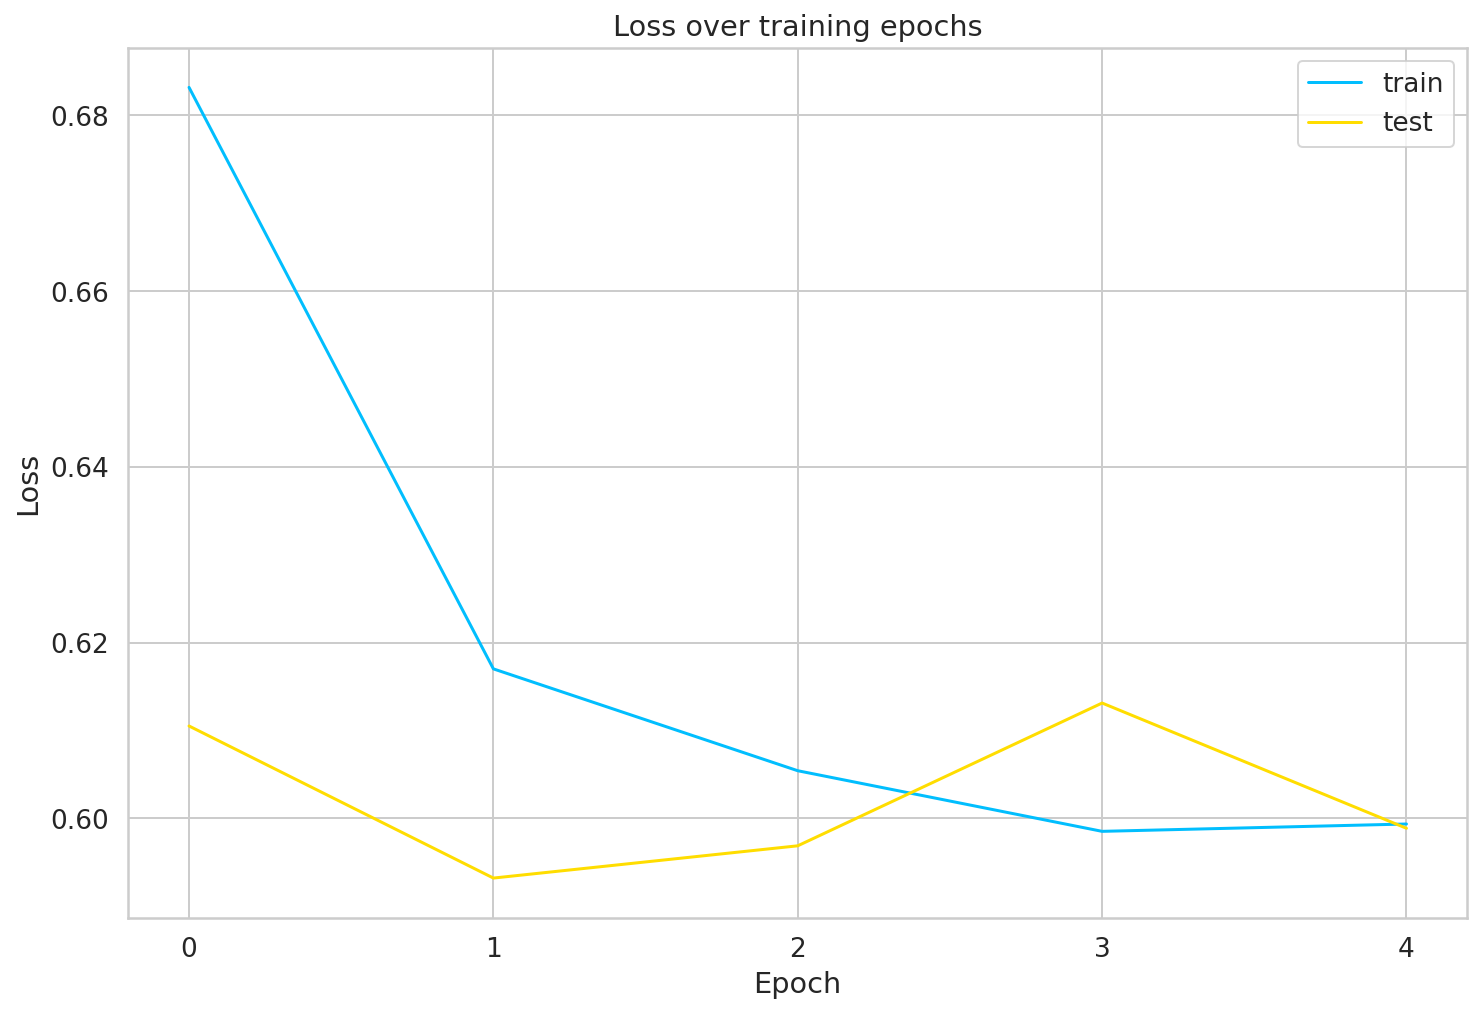

In [35]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

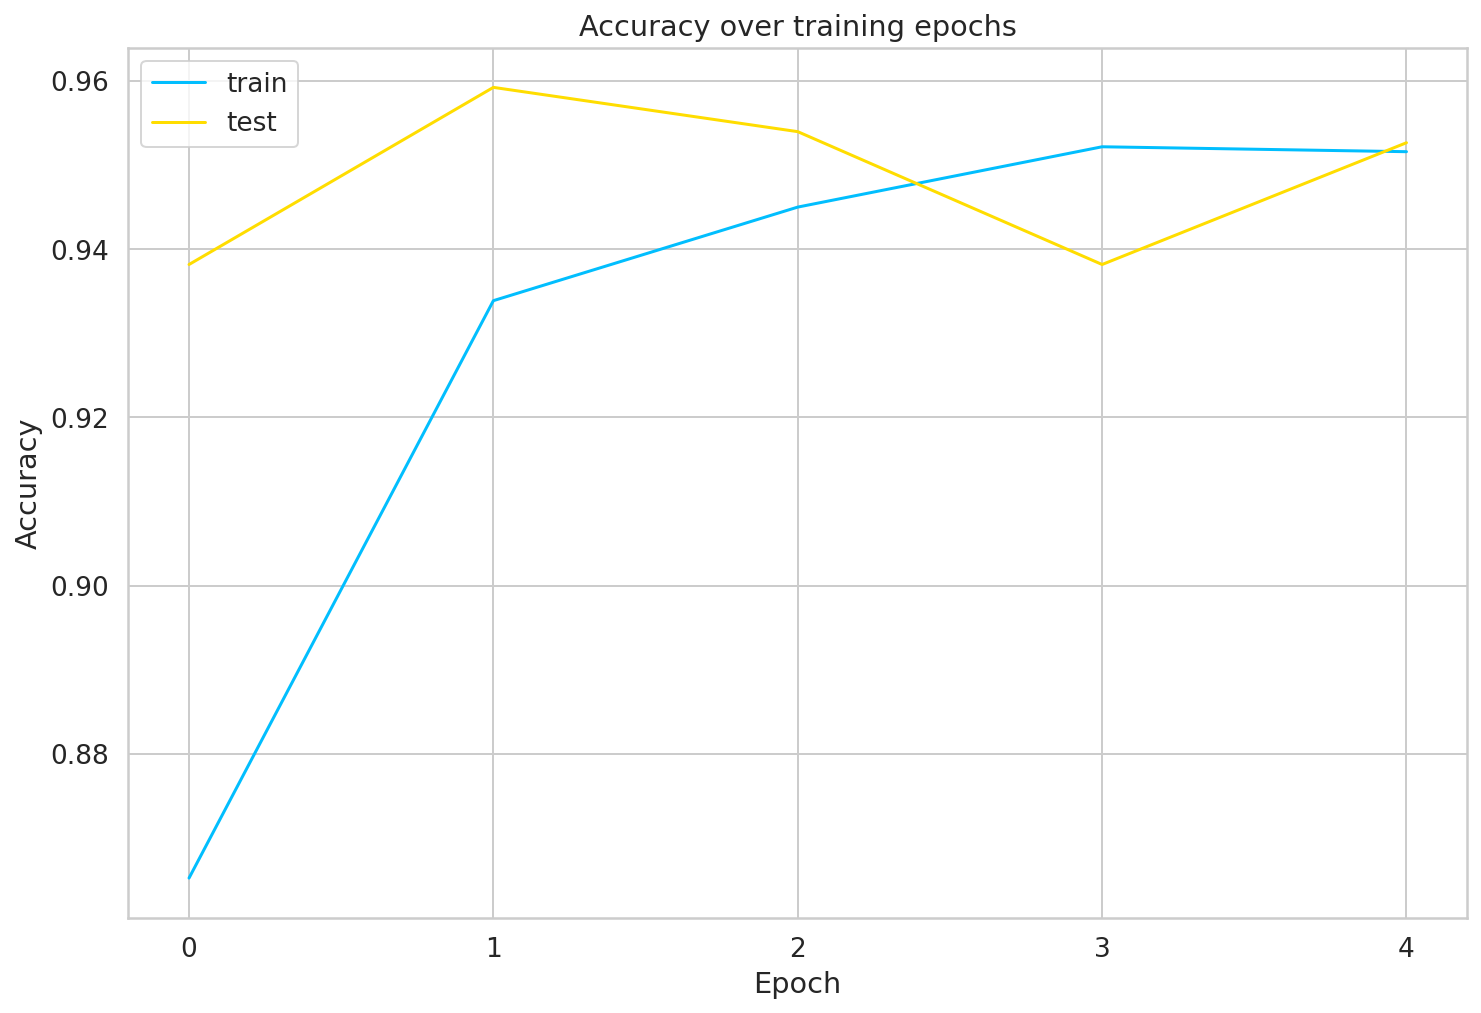

In [36]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [37]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

27/27 [==============================] - 3s 102ms/step - loss: 0.5831 - acc: 0.9680
train acc 0.9560179114341736
test acc 0.9680094718933105


In [38]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [39]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       248
           1       0.98      0.98      0.98       335
           2       0.94      0.97      0.95       261

    accuracy                           0.97       844
   macro avg       0.97      0.97      0.97       844
weighted avg       0.97      0.97      0.97       844



In [40]:

cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

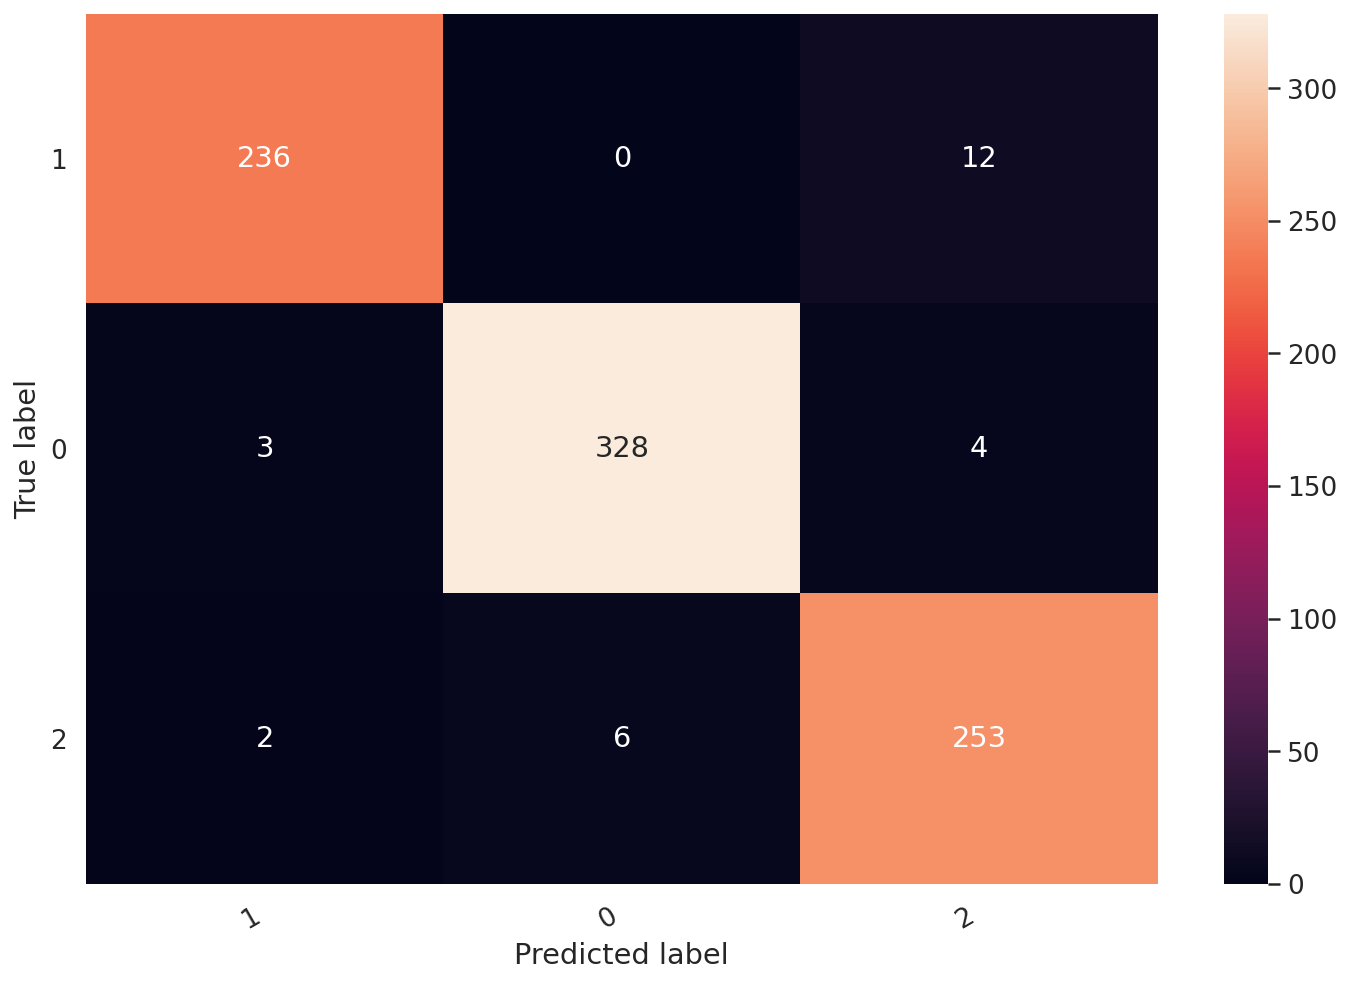

In [41]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# 10 Fold cross validation

In [ ]:
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

kFold = 10

#To get accuracy of the model for 10 different splits
scores = []
training_accuracy = []
testing_accuracy = []
print("BERT: ")
for i in range(kFold):
    print('Fold ', i+1)
    print('')
    # Splitting data into test and train
    train, test = train_test_split(df, test_size=0.10, shuffle = True)

    classes = train.Label.unique().tolist()
    data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)
    model = create_model(data.max_seq_len, bert_ckpt_file)
    history = model.fit( x=data.train_x, y=data.train_y,validation_split=0.1,batch_size=2, shuffle=True,epochs=5)
    #train_loss, train_acc = model.evaluate(data.train_x, data.train_y)
    test_loss, test_acc = model.evaluate(data.test_x, data.test_y)
    
    #training_accuracy.append(train_acc)
    testing_accuracy.append(test_acc)

    y_pred = model.predict(data.test_x).argmax(axis=-1)

    scoreValue =accuracy_score(data.test_y, y_pred)
    scores.append(scoreValue)


234it [00:00, 2334.79it/s]

BERT: 
Fold  1



7594it [00:03, 2351.40it/s]
844it [00:00, 2426.39it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4c072bf240> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
3417/3417 [==============================] - 1659s 486ms/step - loss: 0.7043 - acc: 0.8424 - val_loss: 0.6315 - val_acc: 0.9184
Epoch 2/5
3417/3417 [==============================] - 1586s 464ms/step - loss: 0.6359 - acc: 0.9156 - val_loss: 0.6394 - val_acc: 0.9118
Epoch 3/5
3417/3417 [==============================] - 1554s 455m

226it [00:00, 2254.37it/s]

Fold  2



7594it [00:03, 2298.91it/s]
844it [00:00, 2258.90it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4bfdd979e8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
3417/3417 [==============================] - 1722s 504ms/step - loss: 0.6781 - acc: 0.8682 - val_loss: 0.6275 - val_acc: 0.9224
Epoch 2/5
3417/3417 [==============================] - 1715s 502ms/step - loss: 0.6245 - acc: 0.9258 - val_loss: 0.6367 - val_acc: 0.9145
Epoch 3/5
3417/3417 [==============================] - 1717s 502m

243it [00:00, 2428.47it/s]

Fold  3



7594it [00:03, 2508.26it/s]
844it [00:00, 2480.97it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4c00723160> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
3417/3417 [==============================] - 1604s 469ms/step - loss: 0.6765 - acc: 0.8720 - val_loss: 0.7504 - val_acc: 0.7882
Epoch 2/5
3417/3417 [==============================] - 1512s 442ms/step - loss: 0.6353 - acc: 0.9159 - val_loss: 0.6109 - val_acc: 0.9408
Epoch 3/5
3417/3417 [==============================] - 1499s 439m

220it [00:00, 2198.53it/s]

Fold  4



7594it [00:03, 2354.05it/s]
844it [00:00, 2361.51it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4c07f19128> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
3417/3417 [==============================] - 1492s 437ms/step - loss: 0.6944 - acc: 0.8553 - val_loss: 0.6267 - val_acc: 0.9263
Epoch 2/5
3417/3417 [==============================] - 1486s 435ms/step - loss: 0.6250 - acc: 0.9263 - val_loss: 0.6225 - val_acc: 0.9276
Epoch 3/5
3417/3417 [==============================] - 1497s 438m

217it [00:00, 2169.71it/s]

Fold  5



7594it [00:03, 2386.56it/s]
844it [00:00, 2453.56it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4df0501f60> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
3417/3417 [==============================] - 1498s 438ms/step - loss: 0.7354 - acc: 0.8074 - val_loss: 0.6456 - val_acc: 0.9053
Epoch 2/5
3417/3417 [==============================] - 1494s 437ms/step - loss: 0.6467 - acc: 0.9043 - val_loss: 0.6450 - val_acc: 0.9066
Epoch 3/5
3417/3417 [==============================] - 1495s 437m

235it [00:00, 2348.04it/s]

Fold  6



7594it [00:03, 2296.54it/s]
844it [00:00, 2297.15it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4dce4f1da0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
3417/3417 [==============================] - 1508s 441ms/step - loss: 0.6565 - acc: 0.8924 - val_loss: 0.6109 - val_acc: 0.9408
Epoch 2/5
3417/3417 [==============================] - 1509s 442ms/step - loss: 0.6203 - acc: 0.9305 - val_loss: 0.6102 - val_acc: 0.9408
Epoch 3/5
3417/3417 [==============================] - 1504s 440m

247it [00:00, 2467.29it/s]

Fold  7



7594it [00:03, 2396.66it/s]
844it [00:00, 2387.29it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4dcea6ceb8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
3417/3417 [==============================] - 1567s 459ms/step - loss: 0.6593 - acc: 0.8901 - val_loss: 0.6091 - val_acc: 0.9421
Epoch 2/5
3417/3417 [==============================] - 1516s 444ms/step - loss: 0.6314 - acc: 0.9198 - val_loss: 0.6207 - val_acc: 0.9316
Epoch 3/5
3417/3417 [==============================] - 1495s 438m

255it [00:00, 2539.62it/s]

Fold  8



7594it [00:02, 2560.73it/s]
844it [00:00, 2501.38it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4e12876e48> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
3417/3417 [==============================] - 1531s 448ms/step - loss: 0.7204 - acc: 0.8253 - val_loss: 0.6084 - val_acc: 0.9434
Epoch 2/5
3417/3417 [==============================] - 1496s 438ms/step - loss: 0.6417 - acc: 0.9091 - val_loss: 0.6527 - val_acc: 0.8987
Epoch 3/5
3417/3417 [==============================] - 1496s 438m

240it [00:00, 2396.19it/s]

Fold  9



7594it [00:03, 2337.14it/s]
844it [00:00, 2298.89it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4bfdf86390> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
3417/3417 [==============================] - 1559s 456ms/step - loss: 0.6545 - acc: 0.8957 - val_loss: 0.6013 - val_acc: 0.9500
Epoch 2/5
3417/3417 [==============================] - 1519s 445ms/step - loss: 0.6219 - acc: 0.9293 - val_loss: 0.6041 - val_acc: 0.9474
Epoch 3/5
3417/3417 [==============================] - 1502s 440m

243it [00:00, 2428.38it/s]

Fold  10



7594it [00:03, 2326.57it/s]
844it [00:00, 2328.57it/s]


max seq_len 393
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4bffeb4eb8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
3343/3417 [============================>.] - ETA: 33s - loss: 0.6694 - acc: 0.8780

In [2]:
scores = [0.9289, 0.9480, 0.9301, 0.9301, 0.9526, 0.8412, 0.9348, 0.9182, 0.9502,  0.9076]
testing_accuracy = [0.9289, 0.9480, 0.9301, 0.9301, 0.9526, 0.8412, 0.9348, 0.9182, 0.9502,  0.9076]
print('')
Mean_score = sum(scores) / len(scores)
print(f" Mean predict: {Mean_score}" )

mean_test = sum(testing_accuracy)/len(testing_accuracy)
print(f" Mean testing accuracy for 10 folds: {mean_test}" )


 Mean predict: 0.9241699999999999
 Mean testing accuracy for 10 folds: 0.9241699999999999


In [45]:
translator = Translator()
sentences = []
# 1
hin_text =  "इसलाम सुंदर है"
print("Hindi: ", hin_text)
print("")

trans = translator.translate(hin_text, dest='en')
sentences.append(trans.text)

# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "
print("Hindi: ", hin_text)
print("")

trans = translator.translate(hin_text, dest='en')
sentences.append(trans.text)

# 2
hin_text =  "'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"
print("Hindi: ", hin_text)
print("")
trans = translator.translate(hin_text, dest='en')
sentences.append(trans.text)

# 2
sentences.append( "Play our song now you asshole jehadi muslim")

# 0
sentences.append( "Rate this book as awful")


pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nLabel:", classes[label])
  print()

Hindi:  इसलाम सुंदर है

Hindi:   समाज वादी  पार्टी  जिंदाबाद 

Hindi:  'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂

text: Islam is beautiful 
Label: 1

text: Samajwadi Party Zindabad 
Label: 0

text: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂 
Label: 1

text: Play our song now you asshole jehadi muslim 
Label: 2

text: Rate this book as awful 
Label: 0

